In [1]:
#loading in the necessary libraries
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import datetime as dt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
'''
Stratified K-Fold comes into play for those data sets which are imbalance data sets. This cross validation method 
is a slight variation in the K-Fold cross validation, such that each fold contains approximately same percentage of 
samples of each target class, or in case of prediction problems, the mean response value is approximately equal in 
all the folds.

Repeated means that K-fold is completed many different times possibly
''' 
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib.patches import Circle, Rectangle, Arc

# Question I'm asking: How well can I predict if Curry makes a shot based on information from NBA.com's Advanced Stats page?

In [2]:
'''
importing the data from all of Steph Curry's field goal attempts from NBA.com's Advanced Stats

Used the nba_api library to access the data: https://github.com/swar/nba_api
Specifically using NBA.com's shot chart detail: 
    https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md
    
'''
from nba_api.stats.endpoints import shotchartdetail
shotchart = shotchartdetail.ShotChartDetail(player_id='201939',team_id = '1610612744',context_measure_simple = 'FGA')

In [4]:
'''
viewing the first five rows of the dataframe
'''
Curry = shotchart.get_data_frames()[0]
with pd.option_context('display.max_columns', None):
    display(Curry.head())

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0020900015,4,201939,Stephen Curry,1610612744,Golden State Warriors,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,1,0,20091028,GSW,HOU
1,Shot Chart Detail,0020900015,17,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,1,20091028,GSW,HOU
2,Shot Chart Detail,0020900015,53,201939,Stephen Curry,1610612744,Golden State Warriors,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,1,0,20091028,GSW,HOU
3,Shot Chart Detail,0020900015,141,201939,Stephen Curry,1610612744,Golden State Warriors,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,1,0,20091028,GSW,HOU
4,Shot Chart Detail,0020900015,249,201939,Stephen Curry,1610612744,Golden State Warriors,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,1,0,20091028,GSW,HOU


In [4]:
'''
download the Curry dataframe as a csv file just in case the API request can't access the data at some point
'''
Curry.to_csv(r'/Users/connorcapitolo/Desktop/NBA/Curry shots.csv')

In [5]:
'''
this lets me know that there isn't any missing data in the dataset
also, the two data types are integers and strings
'''
Curry.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11928 entries, 0 to 11927
Data columns (total 24 columns):
GRID_TYPE              11928 non-null object
GAME_ID                11928 non-null object
GAME_EVENT_ID          11928 non-null int64
PLAYER_ID              11928 non-null int64
PLAYER_NAME            11928 non-null object
TEAM_ID                11928 non-null int64
TEAM_NAME              11928 non-null object
PERIOD                 11928 non-null int64
MINUTES_REMAINING      11928 non-null int64
SECONDS_REMAINING      11928 non-null int64
EVENT_TYPE             11928 non-null object
ACTION_TYPE            11928 non-null object
SHOT_TYPE              11928 non-null object
SHOT_ZONE_BASIC        11928 non-null object
SHOT_ZONE_AREA         11928 non-null object
SHOT_ZONE_RANGE        11928 non-null object
SHOT_DISTANCE          11928 non-null int64
LOC_X                  11928 non-null int64
LOC_Y                  11928 non-null int64
SHOT_ATTEMPTED_FLAG    11928 non-null int64
S

In [7]:
'''
looking specifically at shot distance and shot location, it does appears that there are some outliers 
(a shot 78 feet is almost the length of a basketball court!)
'''
Curry.describe()

,GAME_EVENT_ID,PLAYER_ID,TEAM_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
count,11928.000000,11928.0,1.192800e+04,11928.000000,11928.000000,11928.000000,11928.000000,11928.000000,11928.000000,11928.0,11928.000000
mean,266.775319,201939.0,1.610613e+09,2.399061,4.754779,28.580818,17.538565,-0.111502,130.789487,1.0,0.476190
std,168.137684,0.0,0.000000e+00,1.118473,3.337098,17.574401,10.192440,124.382070,101.555442,0.0,0.499454
min,2.000000,201939.0,1.610613e+09,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,1.0,0.000000
25%,106.000000,201939.0,1.610613e+09,1.000000,2.000000,13.000000,9.000000,-95.000000,23.000000,1.0,0.000000
50%,272.000000,201939.0,1.610613e+09,2.000000,4.000000,29.000000,21.000000,1.000000,141.000000,1.0,0.000000
75%,392.000000,201939.0,1.610613e+09,3.000000,7.000000,44.000000,25.000000,96.000000,217.000000,1.0,1.000000
max,752.000000,201939.0,1.610613e+09,6.000000,11.000000,59.000000,78.000000,247.000000,758.000000,1.0,1.000000


## Visualizations of Steph Curry Shots

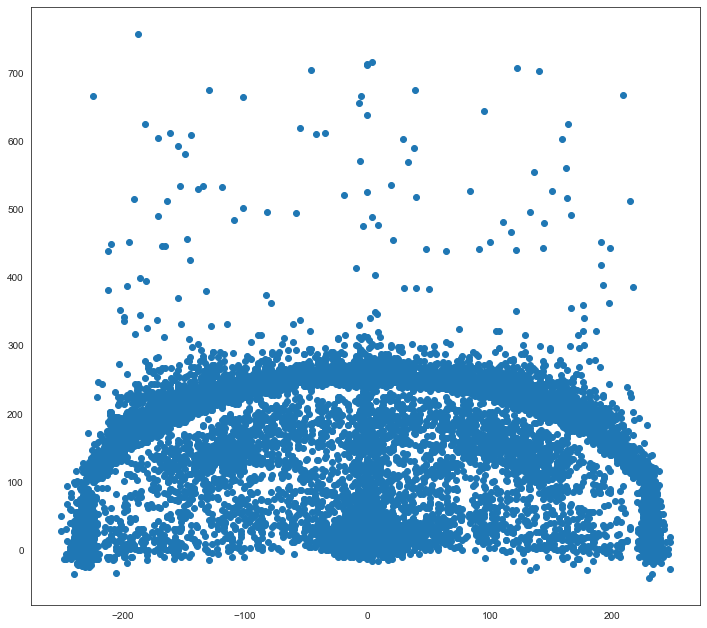

In [8]:
'''
creating a general scatter plot of all Curry's shots
'''
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
plt.scatter(Curry.LOC_X, Curry.LOC_Y)
plt.show()

These were created courtesy of Savvas's visualizations http://savvastjortjoglou.com/nba-shot-sharts.html

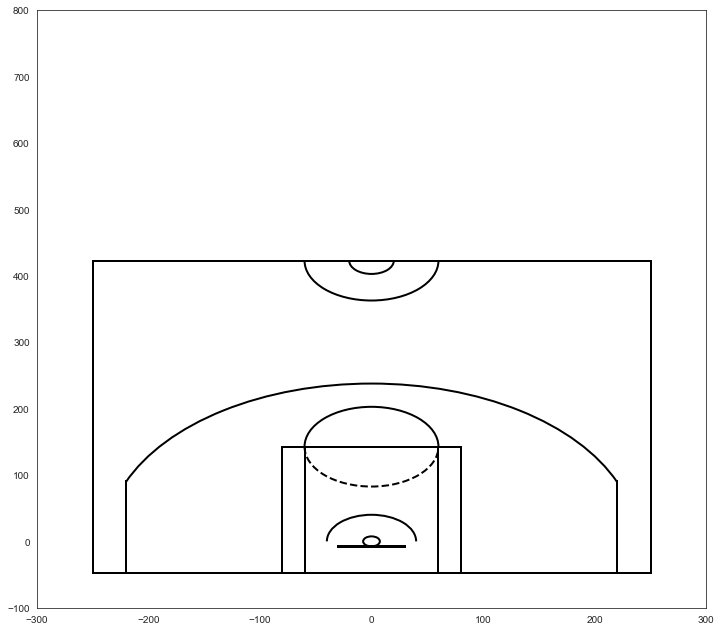

In [10]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    '''Creates a basketball court through matplotlib
    
    Args:
        ax (axis object, optional): If an axes object isn't provided to plot onto, just get current one
        color (string, optional): color of the basketball court
        lw (int, optional): width of each line for the basketball court
        outer_lines (bool, optional): whether the perimeter of the court should be drawn
    '''
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,800)
plt.show()

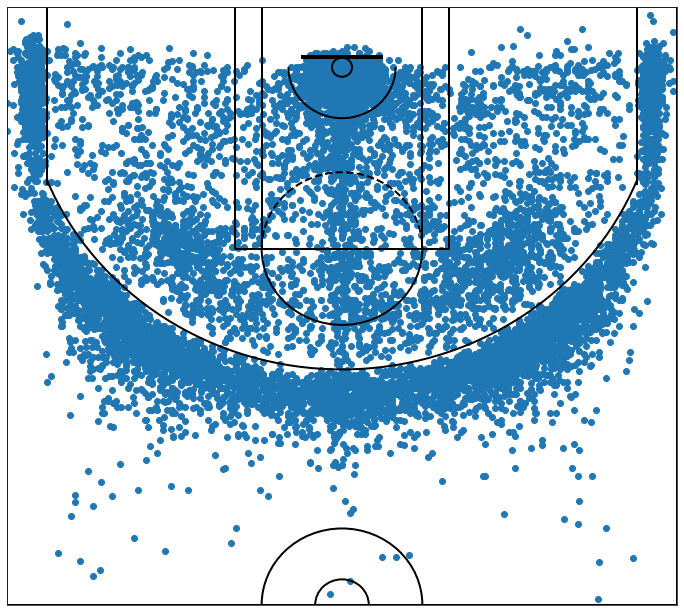

In [11]:
'''
plotting Curry's shots from inside half court
'''
plt.figure(figsize=(12,11))
plt.scatter(Curry.LOC_X, Curry.LOC_Y)
draw_court(outer_lines = True)
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

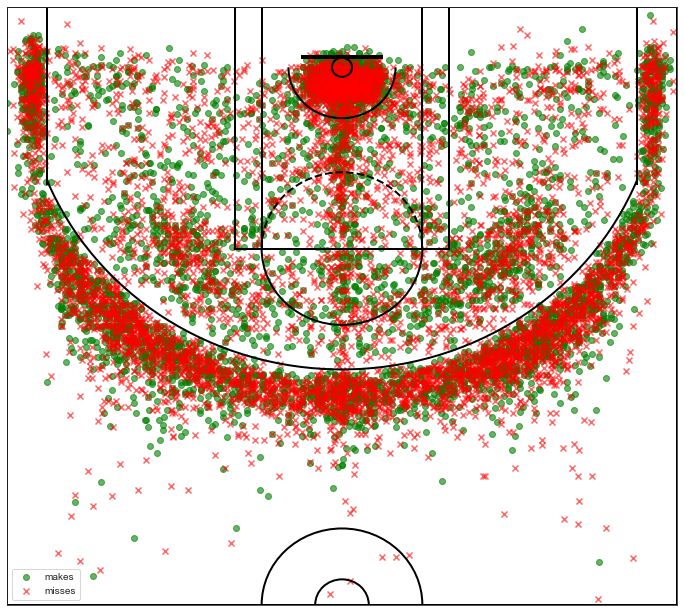

In [11]:
'''
viewing Curry's made and missed shots over the course of his career
'''
plt.figure(figsize=(12,11))
#providing 
plt.scatter(Curry.loc[Curry["SHOT_MADE_FLAG"] == 1,"LOC_X"], 
            Curry.loc[Curry["SHOT_MADE_FLAG"] == 1,"LOC_Y"], c = 'green', label = 'makes', alpha = 0.6)
plt.scatter(Curry.loc[Curry["SHOT_MADE_FLAG"] == 0,"LOC_X"], 
            Curry.loc[Curry["SHOT_MADE_FLAG"] == 0,"LOC_Y"], c = 'red', marker = 'x', label = 'misses', alpha = 0.6)
draw_court(outer_lines = True)
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
#placing the legend in the lower left corner
plt.legend(loc='lower left')
plt.show()

In [28]:
def heatmap_Curry_shots(shot_indicator):
    '''Viewing where most of Curry's shots are made or missed
    
    Args:
        shot_indicator (int): a 1 if wanting to see Curry's makes, 0 if wanting to see Curry's misses
        
    Returns:
        heatmap with Curry's made or missed shots
    '''
    
    # n_levels sets the number of contour lines for the main kde plot
    joint_shot_chart = sns.jointplot(Curry.loc[Curry["SHOT_MADE_FLAG"] == shot_indicator,"LOC_X"], 
                                     Curry.loc[Curry["SHOT_MADE_FLAG"] == shot_indicator,"LOC_Y"], stat_func=None,
                                     kind='kde', cmap = 'hsv',space=0, n_levels=50)

    joint_shot_chart.fig.set_size_inches(12,11)

    # A joint plot has 3 Axes, the first one called ax_joint 
    # is the one we want to draw our court onto and adjust some other settings
    ax = joint_shot_chart.ax_joint
    draw_court(ax)

    # Adjust the axis limits and orientation of the plot in order
    # to plot half court, with the hoop by the top of the plot
    ax.set_xlim(-250,250)
    ax.set_ylim(422.5, -47.5)

    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(labelbottom='off', labelleft='off')

    # Add a title
    if shot_indicator == 1:
        plt.title('Steph Curry Made Shots (Career)')
    else:
        plt.title('Steph Curry Missed Shots (Career)')

    plt.show()

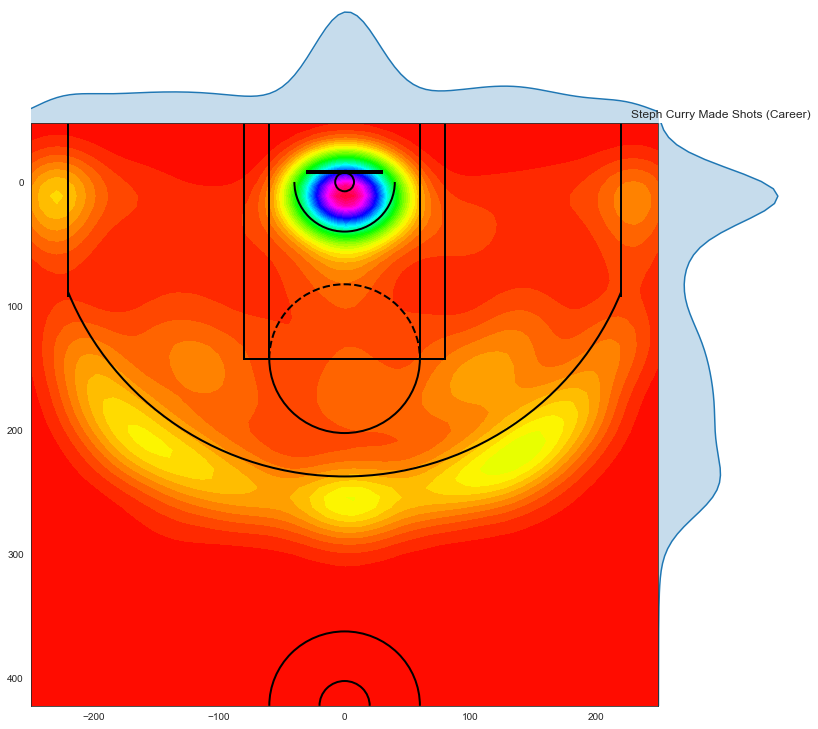

In [29]:
heatmap_Curry_shots(1)

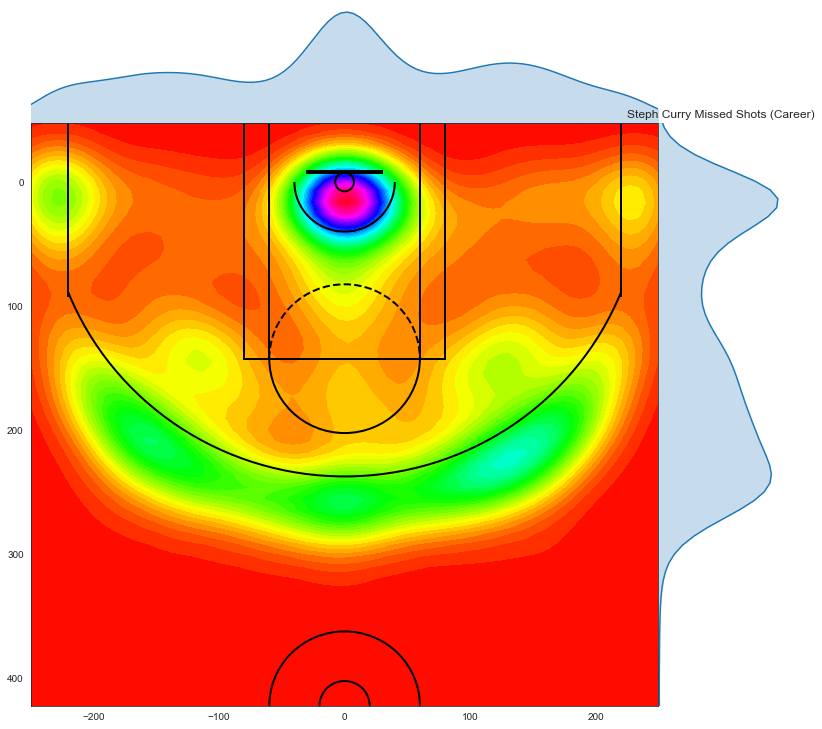

In [30]:
heatmap_Curry_shots(0)

## Dropping Unneccessary Columns

In [32]:
'''
checking how many different values there are in columns that should only have one value for Steph Curry
'''
def only_one_unique(column_list):
    '''print out the unique values in list of columns
    
    Args:
        column_list(list): a list of columns to examine
    '''
    for column in column_list:
        print(Curry[column].unique())
        
columns = ['GRID_TYPE','TEAM_NAME','TEAM_ID','PLAYER_ID','PLAYER_NAME','EVENT_TYPE','SHOT_ATTEMPTED_FLAG']

only_one_unique(columns)

['Shot Chart Detail']
['Golden State Warriors']
[1610612744]
[201939]
['Stephen Curry']
['Missed Shot' 'Made Shot']
[1]


In [33]:
'''
don't need these columns b/c they are all constants throughout the dataset
'''
drop_columns_Curry = Curry.drop(['GRID_TYPE','TEAM_NAME','TEAM_ID','PLAYER_ID','PLAYER_NAME','SHOT_ATTEMPTED_FLAG'],axis = 1)
print(Curry.shape)
print(drop_columns_Curry.shape)

(11928, 24)
(11928, 18)


In [34]:
with pd.option_context('display.max_columns', None):
    display(drop_columns_Curry.head(7))

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,0020900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,20091028,GSW,HOU
1,0020900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,20091028,GSW,HOU
2,0020900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,20091028,GSW,HOU
3,0020900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,20091028,GSW,HOU
4,0020900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,20091028,GSW,HOU
5,0020900015,277,2,0,34,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,20091028,GSW,HOU
6,0020900015,413,4,10,26,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,20091028,GSW,HOU


In [35]:
'''
finding how many shots Curry has made and missed in his career
'''
grouped = drop_columns_Curry.groupby('EVENT_TYPE')
print(grouped['SHOT_MADE_FLAG'].size())

EVENT_TYPE
Made Shot      5680
Missed Shot    6248
Name: SHOT_MADE_FLAG, dtype: int64


In [36]:
'''
examining his percentage of makes and misses over the course of his career
'''
makes = sum(drop_columns_Curry['EVENT_TYPE'] == 'Made Shot') / drop_columns_Curry.shape[0]
misses = sum(drop_columns_Curry['EVENT_TYPE'] == 'Missed Shot') / drop_columns_Curry.shape[0]
print("Curry has made {:.3f}% and has missed {:.3f}% of his shots in his career".format(makes, misses))

Curry has made 0.476% and has missed 0.524% of his shots in his career


# Baseline: If I can build a model that produces better than 0.52 in accuracy, then my model is doing better than the baseline of guessing Curry has missed every shot in his career

## Feature Engineering

In [37]:
'''
examining the columns available after dropping the known unneccesary ones
'''
print(drop_columns_Curry.columns.tolist())

['GAME_ID', 'GAME_EVENT_ID', 'PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM']


In [38]:
'''
examining the types of shots that NBA.com categorizes for Curry
'''
print(drop_columns_Curry['ACTION_TYPE'].unique())
print(len(drop_columns_Curry['ACTION_TYPE'].unique()))

['Jump Shot' 'Step Back Jump shot' 'Pullup Jump shot' 'Layup Shot'
 'Jump Bank Shot' 'Driving Layup Shot' 'Reverse Layup Shot'
 'Running Jump Shot' 'Floating Jump shot' 'Driving Finger Roll Layup Shot'
 'Running Hook Shot' 'Driving Reverse Layup Shot' 'Turnaround Jump Shot'
 'Fadeaway Jump Shot' 'Running Layup Shot' 'Running Bank shot'
 'Jump Hook Shot' 'Turnaround Bank shot' 'Driving Bank Hook Shot'
 'Running Reverse Layup Shot' 'Tip Shot' 'Fadeaway Bank shot' 'Hook Shot'
 'Pullup Bank shot' 'Finger Roll Layup Shot' 'Slam Dunk Shot'
 'Turnaround Fadeaway shot' 'Driving Dunk Shot' 'Driving Jump shot'
 'Hook Bank Shot' 'Driving Bank shot' 'Running Bank Hook Shot'
 'Putback Layup Shot' 'Dunk Shot' 'Driving Hook Shot'
 'Running Slam Dunk Shot' 'Running Finger Roll Layup Shot'
 'Driving Slam Dunk Shot' 'Turnaround Hook Shot'
 'Cutting Finger Roll Layup Shot' 'Cutting Layup Shot'
 'Running Pull-Up Jump Shot' 'Driving Floating Jump Shot'
 'Driving Floating Bank Jump Shot' 'Alley Oop Layup sh

In [39]:
def seconds(period, minutes, seconds):
    '''converting the PERIOD, MINUTES_REMAINING, SECONDS_REMAINING columns into a column that provides the number of 
    seconds into the game the shot occurred
    '''
    periods_completed = period - 1
    minutes_into_quarter = 12 - minutes - 1 #subtracting one makes it works with the seconds
    seconds_completed = 60 - seconds
    return (periods_completed * 720) + (minutes_into_quarter*60) + seconds_completed
  
drop_columns_Curry['Seconds Into Game'] = drop_columns_Curry.apply(lambda x: seconds(x['PERIOD'], 
                                            x['MINUTES_REMAINING'], x['SECONDS_REMAINING']), axis=1)
drop_columns_Curry.head(12)

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,Seconds Into Game
0,0020900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,20091028,GSW,HOU,35
1,0020900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,20091028,GSW,HOU,149
2,0020900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,20091028,GSW,HOU,358
3,0020900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,20091028,GSW,HOU,851
4,0020900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,20091028,GSW,HOU,1301
5,0020900015,277,2,0,34,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,20091028,GSW,HOU,1406
6,0020900015,413,4,10,26,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,20091028,GSW,HOU,2254
7,0020900015,453,4,6,31,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,20091028,GSW,HOU,2489
8,0020900015,487,4,2,25,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,20091028,GSW,HOU,2735
9,0020900015,490,4,1,47,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-125,134,1,20091028,GSW,HOU,2773


In [44]:
'''
examining the 'Season' column
'''
drop_columns_Curry['Season'] = drop_columns_Curry['GAME_DATE']\
                                                    .map(lambda x: dt.datetime.strptime(x,"%Y%m%d").strftime("%Y"))
print(drop_columns_Curry['Season'].describe())
print(drop_columns_Curry['Season'].unique())

count     11928
unique       12
top        2016
freq       1574
Name: Season, dtype: object
['2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018'
 '2019' '2020']


In [41]:
'''
examining how many shots Curry had in each season, starting with the most in 2016

'''
drop_columns_Curry['Season'].value_counts()

2016    1574
2015    1432
2013    1425
2014    1342
2017    1298
2010    1192
2018     967
2019     880
2012     759
2011     729
2009     314
2020      16
Name: Season, dtype: int64

In [42]:
'''
creating a new column that combines data from two separate columns on the location of the shot
'''
drop_columns_Curry['Shot Zone'] = drop_columns_Curry['SHOT_ZONE_BASIC'] + ' on ' + drop_columns_Curry['SHOT_ZONE_AREA']
drop_columns_Curry[['SHOT_ZONE_BASIC','SHOT_ZONE_AREA','Shot Zone']]

,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,Shot Zone
0,Above the Break 3,Right Side Center(RC),Above the Break 3 on Right Side Center(RC)
1,Mid-Range,Left Side Center(LC),Mid-Range on Left Side Center(LC)
2,In The Paint (Non-RA),Center(C),In The Paint (Non-RA) on Center(C)
3,Mid-Range,Left Side(L),Mid-Range on Left Side(L)
4,Mid-Range,Left Side Center(LC),Mid-Range on Left Side Center(LC)
...,...,...,...
11923,Above the Break 3,Right Side Center(RC),Above the Break 3 on Right Side Center(RC)
11924,Above the Break 3,Center(C),Above the Break 3 on Center(C)
11925,Restricted Area,Center(C),Restricted Area on Center(C)
11926,Above the Break 3,Right Side Center(RC),Above the Break 3 on Right Side Center(RC)


In [43]:
'''
creating a new column that says if the shot is from a home game or away game
'''
drop_columns_Curry['Home Game'] = drop_columns_Curry['HTM'].map(lambda x: 1 if x == 'GSW' else 0)
drop_columns_Curry.head(18)

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,...,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,Seconds Into Game,Season,Shot Zone,Home Game
0,0020900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,99,249,0,20091028,GSW,HOU,35,2009,Above the Break 3 on Right Side Center(RC),1
1,0020900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-122,145,1,20091028,GSW,HOU,149,2009,Mid-Range on Left Side Center(LC),1
2,0020900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,-60,129,0,20091028,GSW,HOU,358,2009,In The Paint (Non-RA) on Center(C),1
3,0020900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,-172,82,0,20091028,GSW,HOU,851,2009,Mid-Range on Left Side(L),1
4,0020900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-68,148,0,20091028,GSW,HOU,1301,2009,Mid-Range on Left Side Center(LC),1
5,0020900015,277,2,0,34,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,39,15,0,20091028,GSW,HOU,1406,2009,In The Paint (Non-RA) on Center(C),1
6,0020900015,413,4,10,26,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-64,149,1,20091028,GSW,HOU,2254,2009,Mid-Range on Left Side Center(LC),1
7,0020900015,453,4,6,31,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),...,118,123,1,20091028,GSW,HOU,2489,2009,Mid-Range on Right Side Center(RC),1
8,0020900015,487,4,2,25,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),...,121,162,1,20091028,GSW,HOU,2735,2009,Mid-Range on Right Side Center(RC),1
9,0020900015,490,4,1,47,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-125,134,1,20091028,GSW,HOU,2773,2009,Mid-Range on Left Side Center(LC),1


In [45]:
'''
creating a new column that provides Curry's opponent
'''
def opponent(home, away):
    if home == 'GSW':
        return away
    return home
  
drop_columns_Curry['Opponent'] = drop_columns_Curry.apply(lambda x: opponent(x['HTM'], x['VTM']), axis=1)
drop_columns_Curry[['HTM','VTM','Opponent']]

,HTM,VTM,Opponent
0,GSW,HOU,HOU
1,GSW,HOU,HOU
2,GSW,HOU,HOU
3,GSW,HOU,HOU
4,GSW,HOU,HOU
...,...,...,...
11923,GSW,TOR,TOR
11924,GSW,TOR,TOR
11925,GSW,TOR,TOR
11926,GSW,TOR,TOR


In [46]:
'''
creating a new column based on whether or not the shot was worth 2 points or 3 points
'''
drop_columns_Curry['2PT FG'] = drop_columns_Curry['SHOT_TYPE'].map(lambda x: 1 if x == '2PT Field Goal' else 0)
drop_columns_Curry[['SHOT_TYPE','2PT FG']].head()

,SHOT_TYPE,2PT FG
0,3PT Field Goal,0
1,2PT Field Goal,1
2,2PT Field Goal,1
3,2PT Field Goal,1
4,2PT Field Goal,1


In [47]:
with pd.option_context('display.max_columns', None):
    display(drop_columns_Curry.head())

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,Seconds Into Game,Season,Shot Zone,Home Game,Opponent,2PT FG
0,0020900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,20091028,GSW,HOU,35,2009,Above the Break 3 on Right Side Center(RC),1,HOU,0
1,0020900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,20091028,GSW,HOU,149,2009,Mid-Range on Left Side Center(LC),1,HOU,1
2,0020900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,20091028,GSW,HOU,358,2009,In The Paint (Non-RA) on Center(C),1,HOU,1
3,0020900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,20091028,GSW,HOU,851,2009,Mid-Range on Left Side(L),1,HOU,1
4,0020900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,20091028,GSW,HOU,1301,2009,Mid-Range on Left Side Center(LC),1,HOU,1


In [48]:
drop_columns_Curry.shape

(11928, 24)

### Columns that will be used in the data analysis

In [49]:
drop_columns_Curry.columns.tolist()

['GAME_ID',
 'GAME_EVENT_ID',
 'PERIOD',
 'MINUTES_REMAINING',
 'SECONDS_REMAINING',
 'EVENT_TYPE',
 'ACTION_TYPE',
 'SHOT_TYPE',
 'SHOT_ZONE_BASIC',
 'SHOT_ZONE_AREA',
 'SHOT_ZONE_RANGE',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'SHOT_MADE_FLAG',
 'GAME_DATE',
 'HTM',
 'VTM',
 'Seconds Into Game',
 'Season',
 'Shot Zone',
 'Home Game',
 'Opponent',
 '2PT FG']

In [50]:
'''
Why I don't need specific columns:
    don't need EVENT_TYPE because SHOT_MADE_FLAG is the binary version
    Seconds Into Game condenses period/minutes/seconds
    SHOT_TYPE is now 2PT FG
    SHOT_ZONEs are now condensed to Shot Zone and Shot_Distance
    GameDate, HTM, VTM have been parsed
'''
x_columns_Curry = drop_columns_Curry[[
 'ACTION_TYPE',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'Home Game',
 'Seconds Into Game',
 'Season',
 'Shot Zone',
 'Opponent',
 '2PT FG']]
y_column_Curry = drop_columns_Curry['SHOT_MADE_FLAG']
print(x_columns_Curry.shape)
print(y_column_Curry.shape)

(11928, 10)
(11928,)


# Splitting The Data 

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(x_columns_Curry, y_column_Curry, test_size = 0.25, shuffle = True,
                                                   random_state = 1)

In [55]:
def confirming_stratified_split(y):
    '''examining the number of makes and misses for the training and test sets to confirm they resemble the accuracy
    of Curry's makes and misses in his career (~52% missed, ~48% made)
    
    Args:
        y (Series): y values for the trianing set or the test set that's composed of 0 (misses) and 1 (makes)
    
    Returns:
        misses (float): about how much of the data set is composed of 0
        makes (float): about how much of the data set is composed of 1
    '''
    value_counts = y.value_counts()
    missed_shots_percent = value_counts[0] / value_counts.sum(axis = 0)
    made_shots_percent = value_counts[1] / value_counts.sum(axis = 0)
    misses = round(missed_shots_percent,3)
    makes = round(made_shots_percent,3)
    return misses, makes

In [56]:
'''
examining training set
'''
train_misses, train_makes = confirming_stratified_split(Y_train)
print("In the training set, Curry missed {} of his shots and made {} of his shots".format(train_misses,train_makes))
test_misses, test_makes = confirming_stratified_split(Y_test)
print("In the test set, Curry missed {} of his shots and made {} of his shots".format(test_misses,test_makes))

In the training set, Curry missed 0.526 of his shots and made 0.474 of his shots
In the test set, Curry missed 0.516 of his shots and made 0.484 of his shots


In [65]:
def unique_features(column_list, dataset, df_name):
    '''Checking the number of unique values in the four large category columns for train or test sets
    
    Args:
        column_list (list): the columns to examine
        dataset (DataFrame): either the independent variables for the train or test sets
        df_name (str): identifying whether it's the train or test set
    '''
    for i in column_list:
        print("The column {} has {} unique features in the {} set".format(i,len(dataset[i].unique()), df_name))
    print('\n')

columns = ['ACTION_TYPE','Season','Opponent','Shot Zone']
unique_features(columns, X_train, 'train')
unique_features(columns, X_test, 'test')

The column ACTION_TYPE has 50 unique features in the train set
The column Season has 12 unique features in the train set
The column Opponent has 31 unique features in the train set
The column Shot Zone has 16 unique features in the train set


The column ACTION_TYPE has 40 unique features in the test set
The column Season has 12 unique features in the test set
The column Opponent has 31 unique features in the test set
The column Shot Zone has 16 unique features in the test set




In [66]:
'''
creating instance of one-hot-encoder to see about how many columns the dataset for training will have
handle_unknow = 'ignore' means that the columns present in X_test are just not included
'''
enc = OneHotEncoder(handle_unknown='ignore')
fitting_Xtrain = enc.fit_transform(X_train[['ACTION_TYPE','Season','Opponent','Shot Zone']])
print(fitting_Xtrain.shape)
fitting_Xtest = enc.transform(X_test[['ACTION_TYPE','Season','Opponent','Shot Zone']])
print(fitting_Xtest.shape)

(8946, 109)
(2982, 109)


In [72]:
print(X_train.columns.tolist())
print(X_test.columns.tolist())

['ACTION_TYPE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'Home Game', 'Seconds Into Game', 'Season', 'Shot Zone', 'Opponent', '2PT FG']
['ACTION_TYPE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'Home Game', 'Seconds Into Game', 'Season', 'Shot Zone', 'Opponent', '2PT FG']


# Machine Learning Analysis

Using logistic, LDA, GaussianNB, GradientBoosting, AdaBoosting, SVC, Random Forest, Decision Trees, KNN

In [136]:
models = []
models.append(('LR', LogisticRegression())) 
models.append(('LDA', LinearDiscriminantAnalysis())) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('DT', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB())) 
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBM',GradientBoostingClassifier()))
models.append(('ABM',AdaBoostClassifier()))
#print(models)

[('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)), ('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)), ('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')), ('DT', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                     

In [137]:
def column_transformer(include_standard = 'standardized'):
    '''creates the columns to use for the machine learning model by performing one-hot encoding on the non-binary 
    categorical variablese and possible standardization of numerical variables
    
    Args:
        include_standard (str, optional): whether or not the numerical variables should be standardized
        
    Returns:
        ColumnTransformer: the columns that are used for the ML model and passed to the pipeline
    
    '''
    ohe_vars = ['ACTION_TYPE','Season','Opponent','Shot Zone']
    passthrough_vars = None
    numerical_vars = None
    steps = None
    if include_standard == 'unstandardized':
        passthrough_vars = ['SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'Home Game', 'Seconds Into Game','2PT FG']
    elif include_standard == 'standardized':
        numerical_vars = ['SHOT_DISTANCE', 'LOC_X', 'LOC_Y','2PT FG']
        passthrough_vars = ['Home Game', 'Seconds Into Game']
    else:
        raise NameError('The argument name \'standardized\' or \'unstandardized\' not specified correctly.')
        
        
    if numerical_vars is None:
        steps = [('cat',OneHotEncoder(handle_unknown='ignore'),ohe_vars), ('pass','passthrough',passthrough_vars)]
    else:
        steps = [('cat',OneHotEncoder(handle_unknown='ignore'),ohe_vars), ('num',StandardScaler(),numerical_vars),
             ('pass','passthrough',passthrough_vars)]
    ct = ColumnTransformer(steps, sparse_threshold = 0)
    
    return ct

#### SHOULD SUPPRESS WARNINGS IN FINAL VERSION

In [138]:
def run_models(models, column_transformer, scoring = 'accuracy', pca_components = None, svd_components = None):
    '''Runs 4 different 5-fold cross validations for each model to find its performance
    
    Args:
        models (list of tuples): the first element of the tuple is the model name, and the second element is
            the sklearn model
        column_transform (ColumnTransformer): the result from the column_transformer function
        scoring(str, optional): the scoring metric to use
        pca_components (int, optional): number of components for principal component analysis
        svd_components (int, optional): number of components for singular value decomposition
        
    Returns:
        dictionary: the name of the model as well as the 20 different performance scores
    
    '''
    results= {}
    for name, model in models:
        # wrap the model in a pipeline
        pipeline = None
        if pca_components is not None:
            pca = PCA(n_components = pca_components)
            pipeline = Pipeline(steps=[('t',ct),('pca',pca),('m',model)])
        elif svd_components is not None:
            svd = TruncatedSVD(n_components=svd_components)
            pipeline = Pipeline(steps=[('t',ct),('svd',svd),('m',model)])
        else:
            pipeline = Pipeline(steps=[('t',ct),('m',model)])
        #this means 20 total splits are performed, and it's the same 20 splits for each model
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=1)
        #evaluate the model
        scores = cross_val_score(pipeline, X_train, Y_train, scoring=scoring, cv=cv, verbose = 1)
        # add the scores to the dictionary
        results[name] = scores
        
    return results

In [139]:
def print_and_plot_model_scores(model_results):
    '''prints the model name along with its mean score and standard deviation
    
    Args:
        model_results (dict): keys are the model names, values are the model scores
    
    Prints:
        model names as well as the mean model score and standard deviation
        a box plot that shows the distribution of scores for each model
        
    '''
    for model_name, model_score in model_results.items():
        print('{} has a mean of {} and a standard deviation of {}'.format(model_name, 
                                                    np.format_float_positional(np.mean(model_score), precision=3), 
                                                    np.format_float_positional(np.std(model_score), precision=3)))
    
    fig = plt.figure(figsize=(10,10))
    plt.boxplot(model_results.values(), labels=model_results.keys(), showmeans=True)
    plt.show()

### Unstandardized Variables Model Comparison

In [140]:
%%time
ct = column_transformer('unstandardized')
model_results = run_models(models,ct)

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logisti

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    4.0s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.1s finished
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of 

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureW

CPU times: user 4min 16s, sys: 4 s, total: 4min 20s
Wall time: 4min 5s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   13.0s finished


LR has a mean of 0.657 and a standard deviation of 0.011
LDA has a mean of 0.657 and a standard deviation of 0.011
KNN has a mean of 0.538 and a standard deviation of 0.009
DT has a mean of 0.573 and a standard deviation of 0.013
NB has a mean of 0.599 and a standard deviation of 0.008
SVM has a mean of 0.546 and a standard deviation of 0.008
RF has a mean of 0.619 and a standard deviation of 0.011
GBM has a mean of 0.657 and a standard deviation of 0.01
ABM has a mean of 0.656 and a standard deviation of 0.011


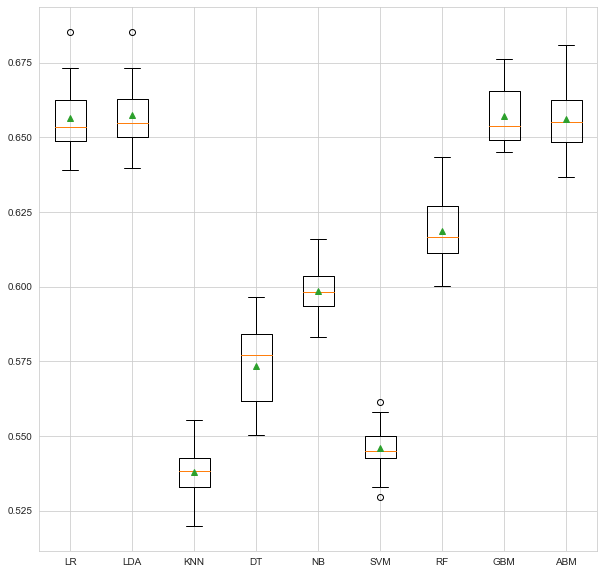

In [141]:
print_and_plot_model_scores(model_results)

### Standardized Variables Model Comparison

In [142]:
%%time
ct = column_transformer()
model_results = run_models(models,ct)

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logisti

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.3s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.6s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.1s finished
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of 

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureW

CPU times: user 4min 4s, sys: 3.37 s, total: 4min 7s
Wall time: 3min 52s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   12.4s finished


LR has a mean of 0.656 and a standard deviation of 0.011
LDA has a mean of 0.657 and a standard deviation of 0.011
KNN has a mean of 0.521 and a standard deviation of 0.008
DT has a mean of 0.571 and a standard deviation of 0.012
NB has a mean of 0.599 and a standard deviation of 0.008
SVM has a mean of 0.516 and a standard deviation of 0.010
RF has a mean of 0.616 and a standard deviation of 0.006
GBM has a mean of 0.657 and a standard deviation of 0.009
ABM has a mean of 0.656 and a standard deviation of 0.011


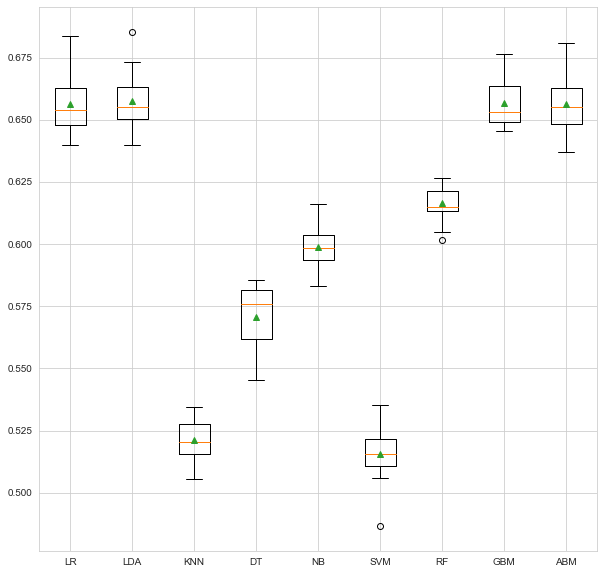

In [143]:
print_and_plot_model_scores(model_results)

This looks very similar to the unstandardized. This is most likely because there's only four variables that need to be standardized, and a large number of categorical variables. I'm going to try out dimensionality reduction with PCA (typically used for dense matrices) and SVD (typically used for sparse matrices).

### Determining number of components for PCA

In [193]:
ct = column_transformer()
pca_X_train = ct.fit_transform(X_train)
print(X_train.shape)
print(pca_X_train.shape)
pca = PCA(n_components = 115).fit(pca_X_train)
pca

(8946, 10)
(8946, 115)


PCA(copy=True, iterated_power='auto', n_components=115, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [194]:
'''
examining the explained variance for each component; the first component explains 99.9% of the variance
'''
pca_explain_var_ratio = pca.explained_variance_ratio_
pca_explain_var_ratio

array([9.99989211e-01, 3.75387756e-06, 1.52556541e-06, 6.24675363e-07,
       4.41708494e-07, 3.25999307e-07, 2.55033168e-07, 1.82604711e-07,
       1.68961173e-07, 1.66452578e-07, 1.63531200e-07, 1.55443181e-07,
       1.43976521e-07, 1.35720372e-07, 1.28238906e-07, 1.26578168e-07,
       1.18306402e-07, 1.08896359e-07, 9.30949895e-08, 8.77733183e-08,
       7.46469900e-08, 7.38074621e-08, 7.01566408e-08, 6.90990655e-08,
       6.75909457e-08, 6.57163459e-08, 6.49240068e-08, 6.45741133e-08,
       6.22722018e-08, 6.07050480e-08, 6.03931251e-08, 5.95678782e-08,
       5.84072489e-08, 5.81607367e-08, 5.70225112e-08, 5.48620869e-08,
       5.33957040e-08, 5.14448636e-08, 4.73870271e-08, 4.45100644e-08,
       4.36824056e-08, 4.08993100e-08, 3.80983661e-08, 3.77143635e-08,
       3.70730247e-08, 3.65270055e-08, 3.59317249e-08, 3.56434321e-08,
       3.46710603e-08, 3.35190408e-08, 3.25365031e-08, 3.13109998e-08,
       2.97807662e-08, 2.95129913e-08, 2.90334616e-08, 2.88810022e-08,
      

Text(0, 0.5, 'cumulative explained variance')

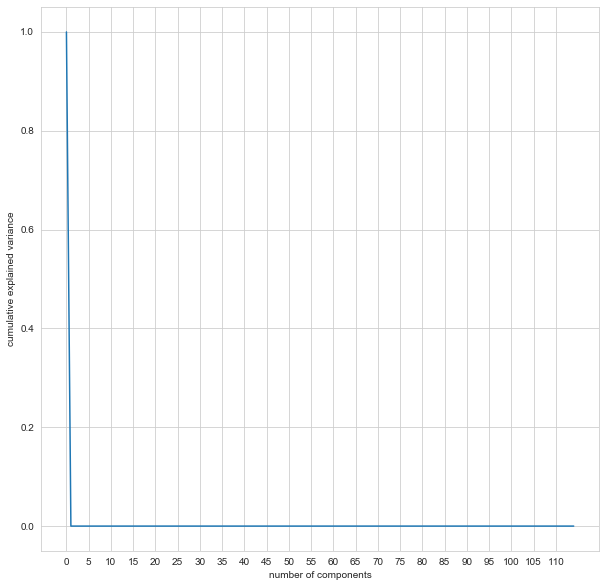

In [195]:
'''
plotting a graph to see the explained variance ratio for each of the components
'''
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
ax.set_xticks(range(0,115,5))
plt.ylabel('cumulative explained variance')

### Examining when only including the main PCA component

In [196]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,pca_components = 1)

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logisti

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcap

CPU times: user 2min 17s, sys: 5.72 s, total: 2min 22s
Wall time: 54.4 s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    5.4s finished


LR has a mean of 0.526 and a standard deviation of 0.000
LDA has a mean of 0.526 and a standard deviation of 0.000
KNN has a mean of 0.504 and a standard deviation of 0.008
DT has a mean of 0.512 and a standard deviation of 0.012
NB has a mean of 0.526 and a standard deviation of 0.000
SVM has a mean of 0.508 and a standard deviation of 0.007
RF has a mean of 0.51 and a standard deviation of 0.011
GBM has a mean of 0.515 and a standard deviation of 0.008
ABM has a mean of 0.520 and a standard deviation of 0.009


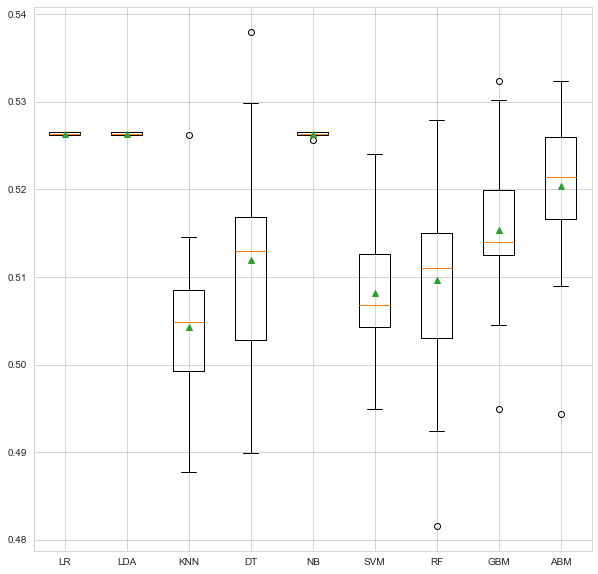

In [197]:
print_and_plot_model_scores(model_results)

In [144]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,pca_components = 25)

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logisti

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcap

CPU times: user 4min 7s, sys: 8.65 s, total: 4min 16s
Wall time: 2min 27s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   26.9s finished


LR has a mean of 0.645 and a standard deviation of 0.011
LDA has a mean of 0.645 and a standard deviation of 0.012
KNN has a mean of 0.522 and a standard deviation of 0.008
DT has a mean of 0.57 and a standard deviation of 0.012
NB has a mean of 0.629 and a standard deviation of 0.01
SVM has a mean of 0.525 and a standard deviation of 0.01
RF has a mean of 0.61 and a standard deviation of 0.013
GBM has a mean of 0.649 and a standard deviation of 0.009
ABM has a mean of 0.640 and a standard deviation of 0.009


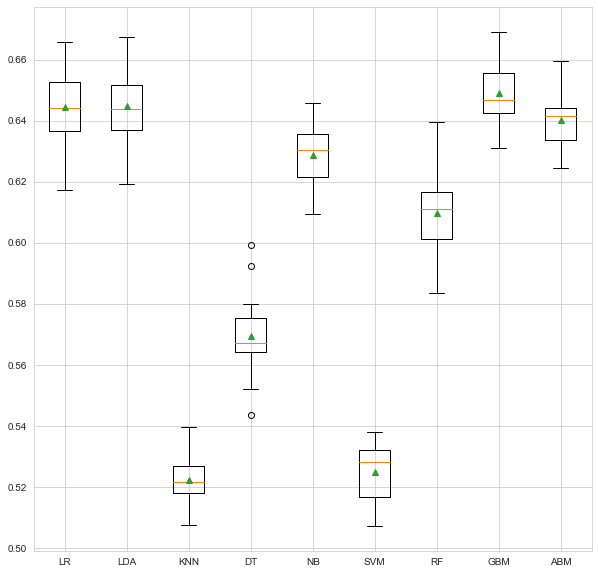

In [145]:
print_and_plot_model_scores(model_results)

It appears from initial analysis that PCA dimensionality reduction doesn't diminish the noise of the data; while it didn't improve most of the models, it did improve the Naive Bayes model

### Checking to see that the results are similar when using ROC performance metric

In [146]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,scoring='roc_auc')

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logisti

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.4s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.7s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.2s finished
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of 

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureW

CPU times: user 4min, sys: 3.19 s, total: 4min 4s
Wall time: 3min 48s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   12.7s finished


LR has a mean of 0.694 and a standard deviation of 0.014
LDA has a mean of 0.695 and a standard deviation of 0.014
KNN has a mean of 0.528 and a standard deviation of 0.009
DT has a mean of 0.570 and a standard deviation of 0.012
NB has a mean of 0.649 and a standard deviation of 0.013
SVM has a mean of 0.531 and a standard deviation of 0.011
RF has a mean of 0.655 and a standard deviation of 0.011
GBM has a mean of 0.709 and a standard deviation of 0.014
ABM has a mean of 0.696 and a standard deviation of 0.013


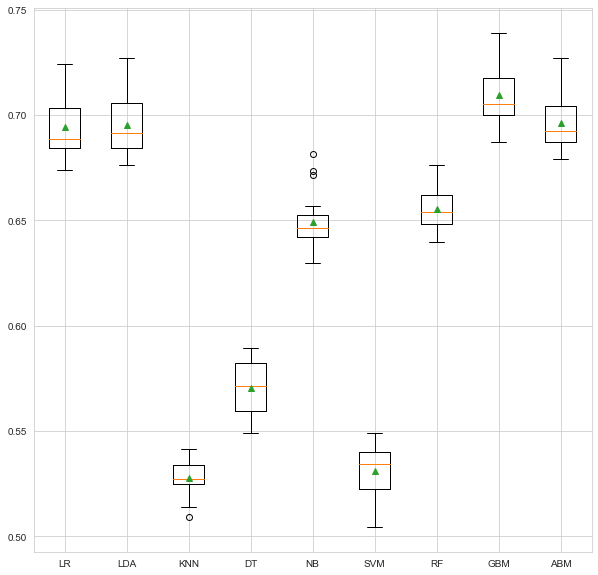

In [147]:
print_and_plot_model_scores(model_results)

Produces similar results with the best scores between logistic regression, LDA, AdaBoost, and Gradient Boosting

### Using SVD to compare model performances

In [166]:
ct = column_transformer()
svd_X_train = ct.fit_transform(X_train)
print(X_train.shape)
print(svd_X_train.shape)
#must be one less b/c there's supposed to be dimensionality reduction
svd = TruncatedSVD(n_components = svd_X_train.shape[1] -1).fit(svd_X_train)

(8946, 10)
(8946, 115)


In [170]:
tsv_explain_var_ratio = svd.explained_variance_ratio_
type(tsv_explain_var_ratio)
print(tsv_explain_var_ratio)
print(sum(tsv_explain_var_ratio))

[9.99988998e-01 3.75446433e-06 1.52803174e-06 6.24677085e-07
 4.30350168e-07 4.27289991e-07 2.94980281e-07 1.82707424e-07
 1.69011307e-07 1.66472725e-07 1.63531467e-07 1.55811306e-07
 1.46104243e-07 1.42954093e-07 1.33244545e-07 1.27919079e-07
 1.19334586e-07 1.08899208e-07 9.53078745e-08 8.87610982e-08
 7.75830363e-08 7.41091363e-08 7.36774287e-08 7.01548053e-08
 6.90952105e-08 6.73138251e-08 6.57067797e-08 6.47863832e-08
 6.45442624e-08 6.21817344e-08 6.07050449e-08 6.02474896e-08
 5.95676631e-08 5.84068710e-08 5.79897897e-08 5.70103091e-08
 5.48350466e-08 5.25766951e-08 4.84864574e-08 4.73475831e-08
 4.37833962e-08 4.20845756e-08 4.05128807e-08 3.79497126e-08
 3.71634413e-08 3.69778008e-08 3.60917870e-08 3.58623673e-08
 3.53630783e-08 3.46384776e-08 3.34424237e-08 3.25002002e-08
 3.12493489e-08 2.97552576e-08 2.90909754e-08 2.88815022e-08
 2.80912403e-08 2.74173132e-08 2.67860339e-08 2.54609318e-08
 1.77081402e-08 1.52855743e-08 1.47156546e-08 1.46511815e-08
 1.31023810e-08 1.198517

In [174]:
tsv_explain_var = svd.explained_variance_
tsv_explain_var

array([7.15488752e+05, 2.68630656e+00, 1.09330155e+00, 4.46954345e-01,
       3.07914092e-01, 3.05724546e-01, 2.11057395e-01, 1.30726545e-01,
       1.20927020e-01, 1.19110673e-01, 1.17006212e-01, 1.11482463e-01,
       1.04537093e-01, 1.02283171e-01, 9.53360223e-02, 9.15256695e-02,
       8.53834933e-02, 7.79170153e-02, 6.81924624e-02, 6.35082661e-02,
       5.55104005e-02, 5.30248368e-02, 5.27159515e-02, 5.01955263e-02,
       4.94373898e-02, 4.81628146e-02, 4.70129790e-02, 4.63544384e-02,
       4.61812018e-02, 4.44908210e-02, 4.34342547e-02, 4.31068754e-02,
       4.26204619e-02, 4.17899190e-02, 4.14914988e-02, 4.07906837e-02,
       3.92342907e-02, 3.76184478e-02, 3.46918966e-02, 3.38770358e-02,
       3.13268721e-02, 3.01113717e-02, 2.89868294e-02, 2.71528912e-02,
       2.65903168e-02, 2.64574916e-02, 2.58235517e-02, 2.56594027e-02,
       2.53021631e-02, 2.47837138e-02, 2.39279413e-02, 2.32537835e-02,
       2.23588036e-02, 2.12897864e-02, 2.08144947e-02, 2.06646173e-02,
      

Text(0, 0.5, 'cumulative explained variance')

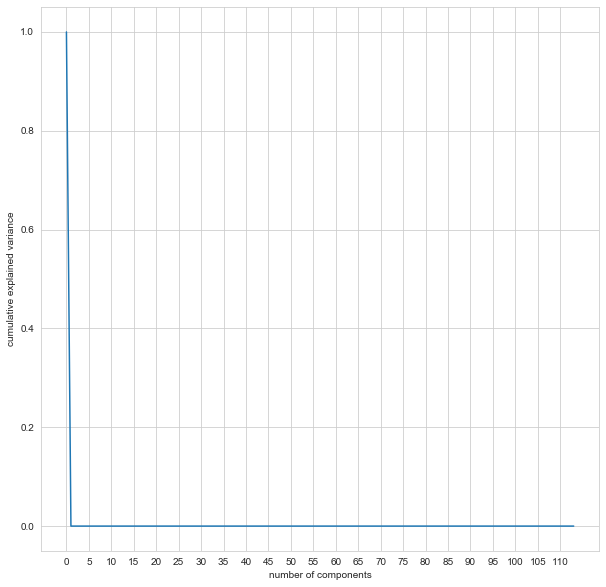

In [173]:
'''
plotting a graph to see the explained variance ratio for each of the components
'''
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(tsv_explain_var_ratio)
plt.xlabel('number of components')
ax.set_xticks(range(0,115,5))
plt.ylabel('cumulative explained variance')

In [175]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,svd_components = 25)

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logisti

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcap

CPU times: user 4min 3s, sys: 5.76 s, total: 4min 9s
Wall time: 2min 18s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   25.0s finished


LR has a mean of 0.640 and a standard deviation of 0.011
LDA has a mean of 0.643 and a standard deviation of 0.011
KNN has a mean of 0.522 and a standard deviation of 0.007
DT has a mean of 0.567 and a standard deviation of 0.013
NB has a mean of 0.631 and a standard deviation of 0.008
SVM has a mean of 0.525 and a standard deviation of 0.01
RF has a mean of 0.607 and a standard deviation of 0.012
GBM has a mean of 0.647 and a standard deviation of 0.010
ABM has a mean of 0.640 and a standard deviation of 0.010


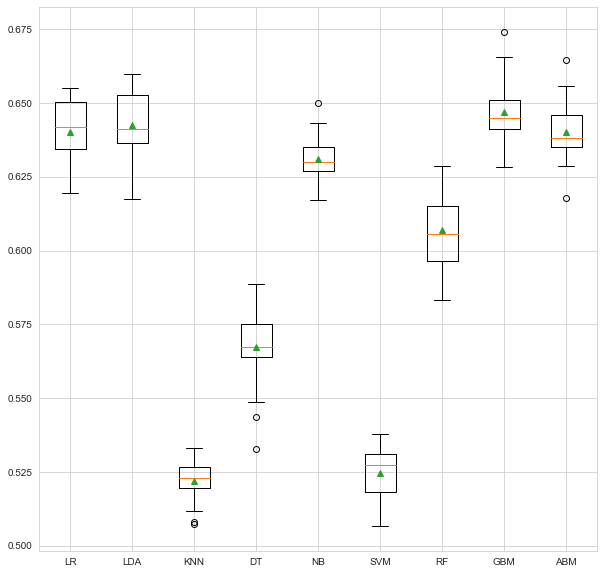

In [176]:
print_and_plot_model_scores(model_results)

In [177]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,svd_components = 1)

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logisti

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcap

CPU times: user 2min 13s, sys: 4.32 s, total: 2min 17s
Wall time: 52.8 s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    5.5s finished


LR has a mean of 0.526 and a standard deviation of 0.000
LDA has a mean of 0.526 and a standard deviation of 0.000
KNN has a mean of 0.506 and a standard deviation of 0.007
DT has a mean of 0.519 and a standard deviation of 0.009
NB has a mean of 0.526 and a standard deviation of 0.000
SVM has a mean of 0.508 and a standard deviation of 0.007
RF has a mean of 0.518 and a standard deviation of 0.008
GBM has a mean of 0.519 and a standard deviation of 0.01
ABM has a mean of 0.522 and a standard deviation of 0.007


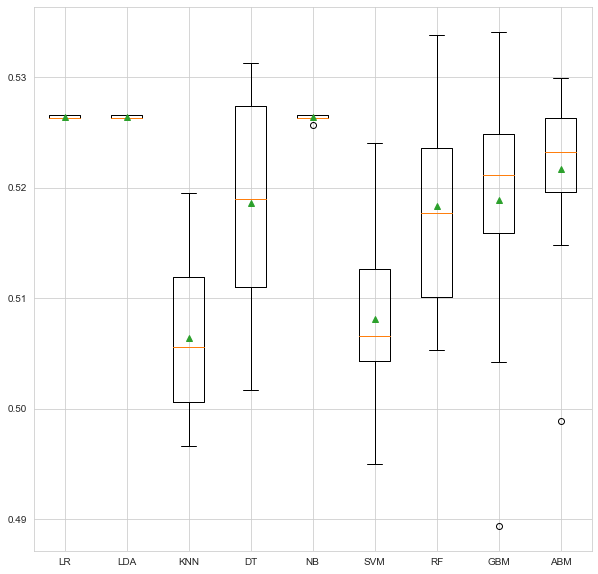

In [178]:
print_and_plot_model_scores(model_results)

In [191]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,svd_components = 55)

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logisti

/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcapitolo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/connorcap

CPU times: user 6min 22s, sys: 8.81 s, total: 6min 31s
Wall time: 4min 19s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   54.5s finished


LR has a mean of 0.654 and a standard deviation of 0.011
LDA has a mean of 0.655 and a standard deviation of 0.012
KNN has a mean of 0.521 and a standard deviation of 0.008
DT has a mean of 0.566 and a standard deviation of 0.015
NB has a mean of 0.613 and a standard deviation of 0.011
SVM has a mean of 0.522 and a standard deviation of 0.010
RF has a mean of 0.603 and a standard deviation of 0.010
GBM has a mean of 0.651 and a standard deviation of 0.009
ABM has a mean of 0.641 and a standard deviation of 0.011


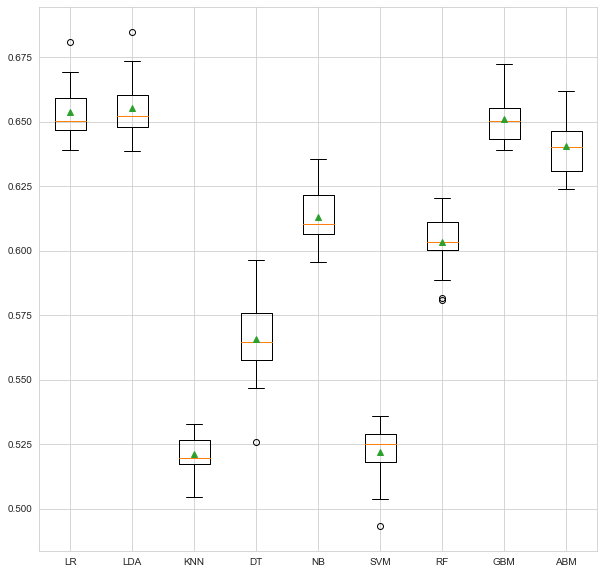

In [192]:
print_and_plot_model_scores(model_results)

It's surprising that 99.99% of the explained variance comes from a single component, but unfortunately using that does not produce better results for any of the algorithms. Having a larger number of components produces similar results to no dimensionality reduction, but still not quite as good

### KNN, SVM, and Decision Trees Showed No Signs of Providing a Good Model

### The best results appeared with the highest mean and lowest standard deviation when there is no dimensionality reduction with logistic regression, LDA, AdaBoost, and GBM

### RandomizedSearchCV for Hyperparameter Tuning...